In [1]:
import torch
print(torch.cuda.is_available())


False


In [2]:
import torch
print(torch.version.cuda)


In [3]:
import torch
print(torch.cuda.device_count())  # 打印可用的GPU数量
print(torch.cuda.current_device())  # 打印当前使用的GPU设备索引
print(torch.cuda.get_device_name(0))  # 打印第一个GPU的名称


In [1]:
%matplotlib inline

from mesa import Mesa
import argparse
from utils import Rater, load_dataset
from sklearn.tree import *
from copy import deepcopy
import time

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser(description='Mesa Arguments')
parser.add_argument('--env-name', default="MESA-SAC")

# SAC arguments
parser.add_argument('--policy', default="Gaussian",
                    help='Policy Type: Gaussian | Deterministic (default: Gaussian)')
parser.add_argument('--eval', type=bool, default=True,
                    help='Evaluates a policy every 10 episode (default: True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.01, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.01)')
parser.add_argument('--lr', type=float, default=0.001, metavar='G',
                    help='learning rate (default: 0.001)')
parser.add_argument('--lr_decay_steps', type=int, default=10, metavar='N',
                    help='step_size of StepLR learning rate decay scheduler (default: 10)')
parser.add_argument('--lr_decay_gamma', type=float, default=0.99, metavar='N',
                    help='gamma of StepLR learning rate decay scheduler (default: 0.99)')
parser.add_argument('--alpha', type=float, default=0.1, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy\
                            term against the reward (default: 0.1)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Automaically adjust α (default: False)')
parser.add_argument('--seed', type=int, default=None, metavar='N',
                    help='random seed (default: None)')
parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='batch size (default: 64)')
parser.add_argument('--hidden_size', type=int, default=50, metavar='N',
                    help='hidden size (default: 50)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simul|ator step (default: 1)')
parser.add_argument('--update_steps', type=int, default=1000, metavar='N',
                    help='maximum number of steps (default: 1000)')
parser.add_argument('--start_steps', type=int, default=500, metavar='N',
                    help='Steps sampling random actions (default: 500)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--replay_size', type=int, default=1000, metavar='N',
                    help='size of replay buffer (default: 1000)')
parser.add_argument('--cuda', action="store_true", default=False,
                    help='run on CUDA (default: False)')

# MESA arguments
parser.add_argument('--dataset', type=str, default='Mammo', metavar='N',
                    help='the dataset used for meta-training (default: Mammo)')
parser.add_argument('--metric', type=str, default='aucprc', metavar='N',
                    help='the metric used for evaluate (default: aucprc)')
parser.add_argument('--reward_coefficient', type=float, default=100, metavar='N')
parser.add_argument('--num_bins', type=int, default=5, metavar='N', 
                    help='number of bins (default: 5). state-size = 2 * num_bins.')

# 高斯函数的sigma使用固定0.2，那么元训练只训练mu
parser.add_argument('--sigma', type=float, default=0.2, metavar='N', 
                    help='sigma of the Gaussian function used in meta-sampling (default: 0.2)')
parser.add_argument('--max_estimators', type=int, default=10, metavar='N',
                    help='maximum number of base estimators in each meta-training episode (default: 10)')
parser.add_argument('--meta_verbose', type=int, default=10, metavar='N',
                    help='number of episodes between verbose outputs. \
                    If \'full\' print log for each base estimator (default: 10)')
parser.add_argument('--meta_verbose_mean_episodes', type=int, default=25, metavar='N',
                    help='number of episodes used for compute latest mean score in verbose outputs.')
parser.add_argument('--verbose', type=bool, default=False, metavar='N',
                    help='enable verbose when ensemble fit (default: False)')
parser.add_argument('--random_state', type=int, default=None, metavar='N', 
                    help='random_state (default: None)')
parser.add_argument('--train_ir', type=float, default=1, metavar='N', 
                    help='imbalance ratio of the training set after meta-sampling (default: 1)')
parser.add_argument('--train_ratio', type=float, default=1, metavar='N', 
                    help='the ratio of the data used in meta-training. \
                    set train_ratio<1 to use a random subset for meta-training (default: 1)')

_StoreAction(option_strings=['--train_ratio'], dest='train_ratio', nargs=None, const=None, default=1, type=<class 'float'>, choices=None, help='the ratio of the data used in meta-training.                     set train_ratio<1 to use a random subset for meta-training (default: 1)', metavar='N')

type of X_train:  <class 'numpy.ndarray'>
type of y_train:  <class 'numpy.ndarray'>
X_train shape:  (36636, 1222)
y_train shape:  (36636,)
X_valid shape:  (9160, 1222)


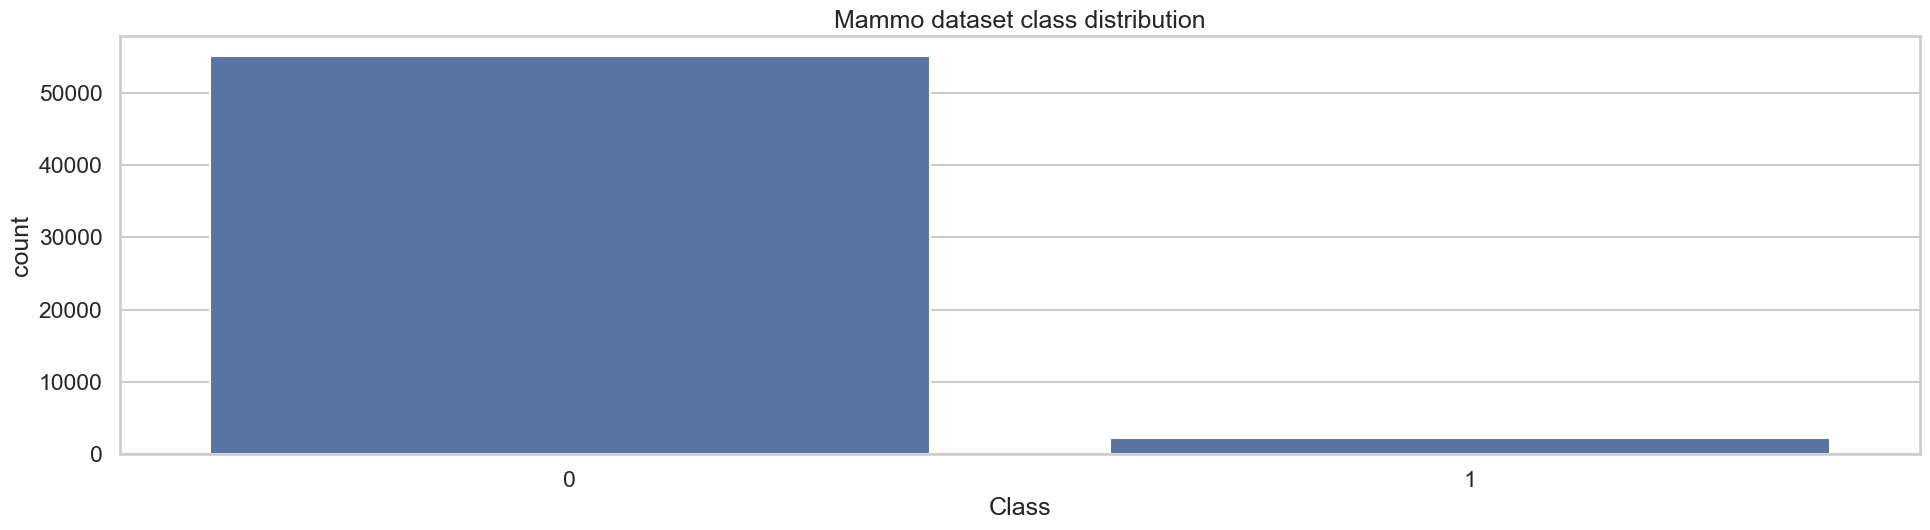

In [4]:
''' Prepare the Environment '''
import seaborn as sns
from sklearn.model_selection import train_test_split
#  load dataset
dataset = 'Mammo'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset(dataset)
X = np.load('dataset/drug_cell_feature.npy')
y = np.load('dataset/drug_cell_label.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("type of X_train: ", type(X_train))
print("type of y_train: ", type(y_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_valid shape: ", X_valid.shape)
estimator, base_estimator = 'DT', DecisionTreeClassifier(max_depth=None)
args = parser.parse_args([])
n_estimators = args.max_estimators

# plot the class distribution
def plot_class_distribution(ax, labels, title):
    sns.countplot(data=pd.DataFrame(labels, columns=['Class']), x='Class', ax=ax)
    ax.set(title=title)
   
sns.set(style='whitegrid')
sns.set_context('talk', font_scale=1)
fig, ax = plt.subplots(figsize=(20, 6))
plot_class_distribution( 
    ax = ax, 
    labels = np.concatenate([y_train, y_valid, y_test]),
    title = f'{dataset} dataset class distribution')
plt.tight_layout(pad=1.8)
plt.show()

In [ ]:
''' Meta-training '''

# initialize MESA
print ('Dataset: {}'.format(dataset))
mesa = Mesa(
    args=args, 
    base_estimator=base_estimator, 
    n_estimators=args.max_estimators)

# start meta-training
print ('Start meta-training of MESA ... ...')
start_time = time.time()
mesa.meta_fit(X_train, y_train, X_valid, y_valid, X_test, y_test)
end_time = time.time()
print ('Meta-training time: {:.3f} s'.format(end_time - start_time))

Dataset: Mammo
Start meta-training of MESA ... ...
meta_fit begin---------------------------------
num_bins: 5
error_in_bins: [0.   0.25 0.5  0.75 1.  ]
unfitted [0.00514093 0.05842767 0.33159046 0.93970625 1.3298076 ]
midfitted [0.33159046 0.93970625 1.3298076  0.93970625 0.33159046]
fitted [1.3298076  0.93970625 0.33159046 0.05842767 0.00514093]
np.concatenate([unfitted, unfitted])
 [0.00514093 0.05842767 0.33159046 0.93970625 1.3298076  0.00514093
 0.05842767 0.33159046 0.93970625 1.3298076 ]
np.concatenate([midfitted, midfitted])
 [0.33159046 0.93970625 1.3298076  0.93970625 0.33159046 0.33159046
 0.93970625 1.3298076  0.93970625 0.33159046]
np.concatenate([fitted, midfitted])
 [1.3298076  0.93970625 0.33159046 0.05842767 0.00514093 0.33159046
 0.93970625 1.3298076  0.93970625 0.33159046]
underfitting_state [0.00964646 0.10963385 0.62219731 1.76326754 2.49525485 0.00964646
 0.10963385 0.62219731 1.76326754 2.49525485]
learning_state [0.42814582 1.21333798 1.71703239 1.21333798 0.42